# Gene vs phospho correlation

This notebook finds the pairwise correlation between all phospho sites.It then finds genes in which the absolute value of all of the correlations is above 0.9, 0.8 ect. 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
import statsmodels.stats.multitest
import math

import cptac
import cptac.utils as u
import plot_utils as p
import warnings
warnings.filterwarnings('ignore')

/Users/Lindsey/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#cptac version
cptac.version()   

'0.8.7'

In [4]:
#load cptac data 
brain = cptac.Gbm()
kidney = cptac.Ccrcc()
ovar = cptac.Ovarian()
colon = cptac.Colon()
brca = cptac.Brca()
luad = cptac.Luad()
hnscc = cptac.Hnscc()
lscc = cptac.Lscc()
endo = cptac.Endometrial()

In [5]:
'''
Takes a cptac data object and makes a dataframe with all phospho sites. 

'''

def get_phospho_data(cancer):
    #get phosphoproteomic data 
    phospho_site = cancer.get_phosphoproteomics("tumor")
    #drop database_id and peptide 
    if (cancer != colon) & (cancer != endo):
        phospho_site = u.reduce_multiindex(phospho_site, levels_to_drop = 2)
        phospho_site = u.reduce_multiindex(phospho_site, levels_to_drop = 2)
        phospho_gene = u.reduce_multiindex(phospho_site, levels_to_drop = 1)
    if (cancer == colon): 
        phospho_site = u.reduce_multiindex(phospho_site, levels_to_drop = 2)
        phospho_gene = u.reduce_multiindex(phospho_site, levels_to_drop = 1)
    if cancer == endo:
         phospho_gene = u.reduce_multiindex(phospho_site, levels_to_drop = 1)
    genes = phospho_gene.columns.to_list() 
    genes = list(set(genes))#get unique list of all genes

    phospho_site.columns =phospho_site.columns.map('_'.join) #join gene and site
    phospho_site = phospho_site.loc[:,~phospho_site.T.duplicated(keep='first')] # drop columns where values are idendical
    phospho_site = phospho_site.dropna(axis=1, thresh=20) # must have atleast 20 non NA
    return phospho_site




In [6]:

'''
Takes a cptac data object and finds all genes that are in phospho site dataframe. 

'''
def get_gene_list(cancer):
    #get phosphoproteomic data 
    phospho_site = cancer.get_phosphoproteomics("tumor")
    #drop database_id and peptide 
    if (cancer != colon) & (cancer != endo):
        phospho_site = u.reduce_multiindex(phospho_site, levels_to_drop = 2)
        phospho_site = u.reduce_multiindex(phospho_site, levels_to_drop = 2)
        phospho_gene = u.reduce_multiindex(phospho_site, levels_to_drop = 1)
    if (cancer == colon): 
        phospho_site = u.reduce_multiindex(phospho_site, levels_to_drop = 2)
        phospho_gene = u.reduce_multiindex(phospho_site, levels_to_drop = 1)
    if cancer == endo:
         phospho_gene = u.reduce_multiindex(phospho_site, levels_to_drop = 1)
    genes = phospho_gene.columns.to_list() 
    genes = list(set(genes))#get unique list of all genes
    return genes

In [7]:
'''
Takes the phospho site data frames and genes and find correlations for all phospho sites within a gene. 
'''

def phospho_gene_site_corr(phospho_df,genes):

    corr_dict = {}
    for gene in genes:
        phospho_gene = phospho_df.filter(regex=gene +"_",axis=1)
        prot_genes_list = phospho_gene.columns.to_list()
       
        if len(prot_genes_list) > 1: # only find correlation if there is more than one site 
        
            site_corrs = phospho_gene.corr(method = "pearson", min_periods = 20) #pairwise correclations
            site_corrs = site_corrs.values.tolist()#array to list
            from pandas.core.common import flatten
            site_corrs = list(flatten(site_corrs))
            site_corrs = [x for x in site_corrs if (math.isnan(x) != True)] #remove na 
       
            
            site_corrs = list(set(site_corrs))# remove duplicate pairwise correlations
            site_corrs.remove(1.0)# remove comparison with same gene
            corr_dict[gene] = site_corrs
           
    return corr_dict
                      

In [8]:
'''
Takes dictionary of genes and correlations and list of genes. Returns dataframe with if all genes 
'''
def phospho_gene_corr_cutoffs(corr_dict,genes):
    genes= corr_dict.keys()
    df = pd.DataFrame() 
    for gene in genes:
        site_corrs = corr_dict[gene]
        abs_val_corrs = [abs(x) for x in site_corrs]
        cutoffs = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
        for corr in cutoffs:

            result = all(x >= corr for x in abs_val_corrs)
            if not abs_val_corrs: #is list empty
                result = False
            df = df.append({'Gene': gene,"Correlation": corr,"Pass_cutoff": result}, ignore_index=True)

        
    return df

In [9]:
gbm_phospho_df = get_phospho_data(brain)
gbm_genes = get_gene_list(brain)
gbm_corr_dict = phospho_gene_site_corr(gbm_phospho_df,gbm_genes)
gbm_corr_dict

{'PTK2': [0.3483645455589557,
  0.6921864807063921,
  0.15002918018743955,
  0.5025078048508794,
  0.20962957590066877,
  0.38791652920411096,
  0.25261356506105154,
  0.15473522342046359,
  0.3181578995537178,
  -0.12766332156571447,
  0.023335334555381674,
  -0.009133561385266156,
  0.0019923344057154544,
  -0.28698282550152826,
  0.493049328717261,
  0.05226394316346335,
  0.06247123494300173,
  0.6077858053129384,
  0.7614624870642452,
  -0.03026606719979306,
  0.19916433882206946,
  -0.07191399750597433,
  0.23359678799616546,
  -0.20516571358644617,
  0.20235706431441094,
  -0.06312958062317944,
  0.16868227879692552,
  0.19130544821606207,
  0.12074752441187772,
  -0.2210173921947204,
  0.12701191869982206,
  0.1608195430811519,
  0.3658698771669835,
  0.06178674157992551,
  0.1981038933042243,
  0.016220687037134286,
  0.731403063363888,
  -0.07520551444975539,
  0.1157427515365718,
  -0.0793226378405081,
  0.0891630127316159,
  0.01662966669597553,
  0.11100742609105806,
  0.4

In [10]:
gbm_corr_df = phospho_gene_corr_cutoffs(gbm_corr_dict,gbm_genes)
gbm_corr_df

Correlation   Gene  Pass_cutoff
0              0.9   PTK2          0.0
1              0.8   PTK2          0.0
2              0.7   PTK2          0.0
3              0.6   PTK2          0.0
4              0.5   PTK2          0.0
...            ...    ...          ...
47614          0.5  EPS15          0.0
47615          0.4  EPS15          0.0
47616          0.3  EPS15          0.0
47617          0.2  EPS15          0.0
47618          0.1  EPS15          0.0

[47619 rows x 3 columns]

In [169]:
print("Total number of gene correlation measured")
num_genes_corr = gbm_corr_df.Gene.to_list()
num_genes_corr = len(set(num_genes_corr))
print(num_genes_corr)

print("Total number pass atleast 0.1")
gbm_df_pass = gbm_corr_df.loc[gbm_corr_df['Pass_cutoff'] == 1.0]
gbm_df_pass_1 = gbm_corr_pass.loc[gbm_corr_pass['Correlation'] == 0.1]
print(len(gbm_df_pass_1))
print(len(gbm_df_pass_1)/num_genes_corr)
print("Didn't pass 0.1 cutoff")
gbm_df_1 = gbm_corr_df.loc[gbm_corr_df['Correlation'] == 0.1]
gbm_df_1_no = gbm_corr_1.loc[gbm_corr_1['Pass_cutoff'] == 0.0]
print(len(gbm_df_1_no))

Total number of gene correlation measured
5291
Total number pass atleast 0.1
1979
0.37403137403137404
Didn't pass 0.1 cutoff
3312


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1ebbc6d30>]],
      dtype=object)

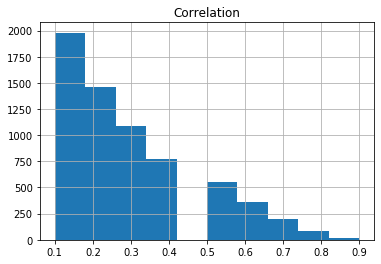

In [157]:
gbm_corr_pass = gbm_corr_df.loc[gbm_corr_df['Pass_cutoff'] == 1.0]
gbm_corr_pass.hist(column= "Correlation")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc204ba54e0>]],
      dtype=object)

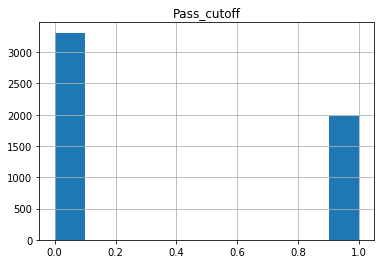

In [181]:
gbm_corr_1 = gbm_corr_df.loc[gbm_corr_df['Correlation'] == 0.1]
gbm_corr_1.hist(column= "Pass_cutoff")


In [ ]:
gbm_df_pass = gbm_corr_df.loc[gbm_corr_df['Pass_cutoff'] == 1.0]
gbm_df_pass

In [185]:
gbm_df_9_pass = gbm_df_pass.loc[gbm_df_pass['Correlation'] == 0.9]
gbm_df_9_pass


Correlation       Gene  Pass_cutoff
2277           0.9       GJB1          1.0
3609           0.9  SERPINA10          1.0
3825           0.9      PDIA4          1.0
3915           0.9       MCM6          1.0
14292          0.9      SYTL3          1.0
15345          0.9      ITGA3          1.0
21861          0.9    SELENOH          1.0
24381          0.9    FAM110C          1.0
25092          0.9      ITGA5          1.0
26649          0.9       LRP4          1.0
35523          0.9       GAS2          1.0
38340          0.9      MGST3          1.0
41850          0.9      GPR39          1.0
43479          0.9    C7orf57          1.0
45801          0.9    SLC17A7          1.0

# Breast

In [158]:
brca_phospho_df = get_phospho_data(brca)
brca_genes = get_gene_list(brca)
brca_corr_dict = phospho_gene_site_corr(brca_phospho_df,brca_genes)
brca_corr_dict

{'DNAJC5': [0.6102057624588343, 0.7182763983347996, 0.396815801668356],
 'AFAP1L1': [0.36371723428107716,
  0.5537061081806441,
  0.23177747965509937,
  0.6035573357679817,
  0.3501885084769718,
  0.3423469691610048,
  0.05365183243949534,
  0.3257367949808434,
  0.31135971257096307,
  0.23584426370650247,
  0.11238621711130044,
  0.2656396689164606,
  0.30620506736429803,
  0.02117691942244067,
  0.25144705798176825,
  0.0032535310098339093,
  0.5098738756824134,
  0.2433290611874587,
  0.5100670914282789,
  0.49567969672381856],
 'KIF22': [-0.3178511554014498,
  -0.36047908048075883,
  0.5567978236626521,
  -0.22494721316615016,
  0.5545470536979438,
  0.5990731271127877],
 'PDE4DIP': [0.30737830515483194,
  0.31545341826562395,
  0.4293526660281925,
  0.42626387155200496,
  0.13653175422948854,
  0.13039019545830016,
  0.25845493324173097,
  0.549359623159457,
  0.11354049608582184,
  0.13483249632922784,
  -0.07330459253290326,
  0.5625959174902051,
  0.31414500654590727,
  0.50163

In [159]:
brca_corr_df = phospho_gene_corr_cutoffs(brca_corr_dict,brca_genes)
brca_corr_df

Correlation      Gene  Pass_cutoff
0              0.9    DNAJC5          0.0
1              0.8    DNAJC5          0.0
2              0.7    DNAJC5          0.0
3              0.6    DNAJC5          0.0
4              0.5    DNAJC5          0.0
...            ...       ...          ...
44320          0.5  DYNC1LI2          0.0
44321          0.4  DYNC1LI2          0.0
44322          0.3  DYNC1LI2          0.0
44323          0.2  DYNC1LI2          0.0
44324          0.1  DYNC1LI2          0.0

[44325 rows x 3 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1fec7d978>]],
      dtype=object)

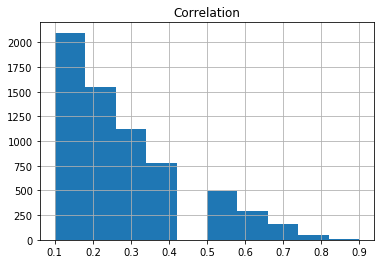

In [178]:
brca_corr_pass = brca_corr_df.loc[brca_corr_df['Pass_cutoff'] == 1.0]
brca_corr_pass.hist(column= "Correlation")

# HNSCC 

In [170]:
hnscc_phospho_df = get_phospho_data(hnscc)
hnscc_genes = get_gene_list(hnscc)
hnscc_corr_dict = phospho_gene_site_corr(hnscc_phospho_df,hnscc_genes)
hnscc_corr_df = phospho_gene_corr_cutoffs(hnscc_corr_dict,hnscc_genes)
hnscc_corr_df

Correlation      Gene  Pass_cutoff
0              0.9   AFAP1L1          0.0
1              0.8   AFAP1L1          0.0
2              0.7   AFAP1L1          0.0
3              0.6   AFAP1L1          0.0
4              0.5   AFAP1L1          0.0
...            ...       ...          ...
42025          0.5  DYNC1LI2          0.0
42026          0.4  DYNC1LI2          0.0
42027          0.3  DYNC1LI2          0.0
42028          0.2  DYNC1LI2          0.0
42029          0.1  DYNC1LI2          0.0

[42030 rows x 3 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc26c309320>]],
      dtype=object)

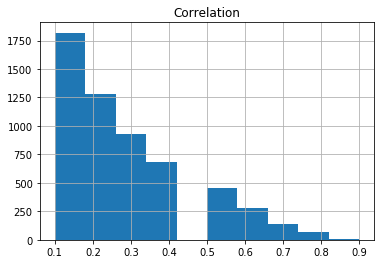

In [184]:
hnscc_corr_pass = hnscc_corr_df.loc[hnscc_corr_df['Pass_cutoff'] == 1.0]
hnscc_corr_pass.hist(column= "Correlation")

# LSCC

In [171]:
lscc_phospho_df = get_phospho_data(lscc)
lscc_genes = get_gene_list(lscc)
lscc_corr_dict = phospho_gene_site_corr(lscc_phospho_df,lscc_genes)
lscc_corr_df = phospho_gene_corr_cutoffs(lscc_corr_dict,lscc_genes)
lscc_corr_df

Correlation      Gene  Pass_cutoff
0              0.9    DNAJC5          0.0
1              0.8    DNAJC5          0.0
2              0.7    DNAJC5          0.0
3              0.6    DNAJC5          0.0
4              0.5    DNAJC5          0.0
...            ...       ...          ...
47812          0.5  DYNC1LI2          0.0
47813          0.4  DYNC1LI2          0.0
47814          0.3  DYNC1LI2          0.0
47815          0.2  DYNC1LI2          0.0
47816          0.1  DYNC1LI2          0.0

[47817 rows x 3 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1c41db7f0>]],
      dtype=object)

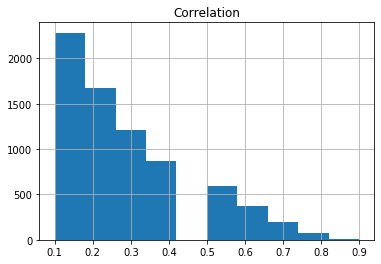

In [186]:
lscc_corr_pass = lscc_corr_df.loc[lscc_corr_df['Pass_cutoff'] == 1.0]
lscc_corr_pass.hist(column= "Correlation")

# LUAD

In [172]:
luad_phospho_df = get_phospho_data(luad)
luad_genes = get_gene_list(luad)
luad_corr_dict = phospho_gene_site_corr(luad_phospho_df,luad_genes)
luad_corr_df = phospho_gene_corr_cutoffs(luad_corr_dict,luad_genes)
luad_corr_df

Correlation      Gene  Pass_cutoff
0              0.9    DNAJC5          0.0
1              0.8    DNAJC5          0.0
2              0.7    DNAJC5          1.0
3              0.6    DNAJC5          1.0
4              0.5    DNAJC5          1.0
...            ...       ...          ...
46507          0.5  DYNC1LI2          0.0
46508          0.4  DYNC1LI2          0.0
46509          0.3  DYNC1LI2          0.0
46510          0.2  DYNC1LI2          0.0
46511          0.1  DYNC1LI2          0.0

[46512 rows x 3 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1c42fa208>]],
      dtype=object)

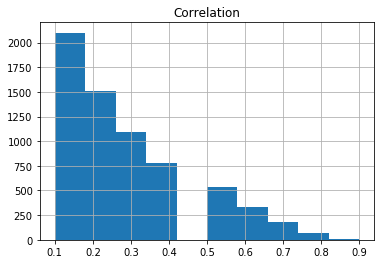

In [187]:
luad_corr_pass = luad_corr_df.loc[luad_corr_df['Pass_cutoff'] == 1.0]
luad_corr_pass.hist(column= "Correlation")

# Kidney

In [173]:
kidney_phospho_df = get_phospho_data(kidney)
kidney_genes = get_gene_list(kidney)
kidney_corr_dict = phospho_gene_site_corr(kidney_phospho_df,kidney_genes)
kidney_corr_df = phospho_gene_corr_cutoffs(kidney_corr_dict,kidney_genes)
kidney_corr_df

Correlation      Gene  Pass_cutoff
0              0.9    DNAJC5          0.0
1              0.8    DNAJC5          0.0
2              0.7    DNAJC5          0.0
3              0.6    DNAJC5          0.0
4              0.5    DNAJC5          0.0
...            ...       ...          ...
45382          0.5  DYNC1LI2          0.0
45383          0.4  DYNC1LI2          0.0
45384          0.3  DYNC1LI2          0.0
45385          0.2  DYNC1LI2          0.0
45386          0.1  DYNC1LI2          0.0

[45387 rows x 3 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1c42fa7b8>]],
      dtype=object)

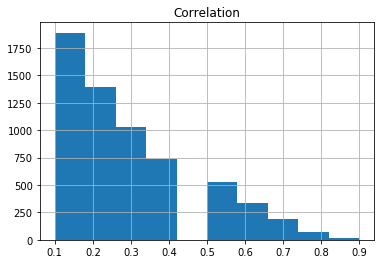

In [188]:
kidney_corr_pass = kidney_corr_df.loc[gbm_corr_df['Pass_cutoff'] == 1.0]
kidney_corr_pass.hist(column= "Correlation")

# Colon

In [174]:
colon_phospho_df = get_phospho_data(colon)
colon_genes = get_gene_list(colon)
colon_corr_dict = phospho_gene_site_corr(colon_phospho_df,colon_genes)
colon_corr_df = phospho_gene_corr_cutoffs(colon_corr_dict,colon_genes)
colon_corr_df

Correlation      Gene  Pass_cutoff
0              0.9    DNAJC5          0.0
1              0.8    DNAJC5          0.0
2              0.7    DNAJC5          1.0
3              0.6    DNAJC5          1.0
4              0.5    DNAJC5          1.0
...            ...       ...          ...
26419          0.5  DYNC1LI2          0.0
26420          0.4  DYNC1LI2          0.0
26421          0.3  DYNC1LI2          0.0
26422          0.2  DYNC1LI2          0.0
26423          0.1  DYNC1LI2          0.0

[26424 rows x 3 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1eecaa358>]],
      dtype=object)

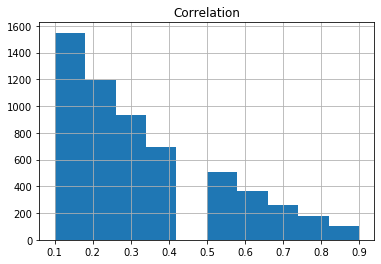

In [189]:
colon_corr_pass = colon_corr_df.loc[colon_corr_df['Pass_cutoff'] == 1.0]
colon_corr_pass.hist(column= "Correlation")

# Ovarian

In [175]:
ovar_phospho_df = get_phospho_data(ovar)
ovar_genes = get_gene_list(ovar)
ovar_corr_dict = phospho_gene_site_corr(ovar_phospho_df,ovar_genes)
ovar_corr_df = phospho_gene_corr_cutoffs(ovar_corr_dict,ovar_genes)
ovar_corr_df

Correlation      Gene  Pass_cutoff
0              0.9    DNAJC5          0.0
1              0.8    DNAJC5          0.0
2              0.7    DNAJC5          0.0
3              0.6    DNAJC5          0.0
4              0.5    DNAJC5          0.0
...            ...       ...          ...
26806          0.5  DYNC1LI2          0.0
26807          0.4  DYNC1LI2          0.0
26808          0.3  DYNC1LI2          1.0
26809          0.2  DYNC1LI2          1.0
26810          0.1  DYNC1LI2          1.0

[26811 rows x 3 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc22c3a01d0>]],
      dtype=object)

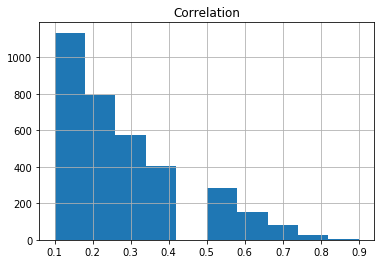

In [190]:
ovar_corr_pass = ovar_corr_df.loc[ovar_corr_df['Pass_cutoff'] == 1.0]
ovar_corr_pass.hist(column= "Correlation")

# Endometrial

In [177]:
endo_phospho_df = get_phospho_data(endo)
endo_genes = get_gene_list(endo)
endo_corr_dict = phospho_gene_site_corr(endo_phospho_df,endo_genes)
endo_corr_df = phospho_gene_corr_cutoffs(endo_corr_dict,endo_genes)
endo_corr_df

Correlation      Gene  Pass_cutoff
0              0.9    DNAJC5          0.0
1              0.8    DNAJC5          0.0
2              0.7    DNAJC5          0.0
3              0.6    DNAJC5          0.0
4              0.5    DNAJC5          1.0
...            ...       ...          ...
43078          0.5  DYNC1LI2          0.0
43079          0.4  DYNC1LI2          0.0
43080          0.3  DYNC1LI2          0.0
43081          0.2  DYNC1LI2          0.0
43082          0.1  DYNC1LI2          1.0

[43083 rows x 3 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc22c3a0ba8>]],
      dtype=object)

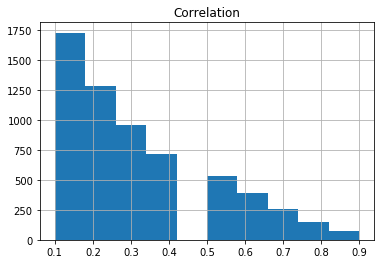

In [192]:
endo_corr_pass = endo_corr_df.loc[endo_corr_df['Pass_cutoff'] == 1.0]
endo_corr_pass.hist(column= "Correlation")

In [193]:
def phospho_gene_vs_site_test(phospho_df,genes):
    corr_dict = {}
    for gene in genes:
        phospho_gene = phospho_df.filter(regex="DYNC1LI2" +"_",axis=1)
        prot_genes_list = phospho_gene.columns.to_list()
       
        if len(prot_genes_list) > 1: # only find correlation if there is more than one site 
        
            site_corrs = phospho_gene.corr(method = "pearson") #pairwise correclations
            '''
            site_corrs = site_corrs.values.tolist()#array to list
            from pandas.core.common import flatten
            site_corrs = list(flatten(site_corrs))
            site_corrs = [x for x in site_corrs if (math.isnan(x) != True)] #remove na 
       
           
            site_corrs = list(set(site_corrs))# remove duplicate pairwise correlations
            site_corrs.remove(1.0)# remove comparison with same gene
            corr_dict[gene] = site_corrs
            '''
            
    return site_corrs

In [194]:
gbm_df = phospho_gene_vs_site_test(gbm_phospho_df,["DYNC1LI2"])

gbm_df

DYNC1LI2_S194  DYNC1LI2_S194  DYNC1LI2_S205  DYNC1LI2_S205  \
DYNC1LI2_S194           1.000000       0.531837       0.264394       0.367887   
DYNC1LI2_S194           0.531837       1.000000       0.356699       0.517123   
DYNC1LI2_S205           0.264394       0.356699       1.000000       0.808004   
DYNC1LI2_S205           0.367887       0.517123       0.808004       1.000000   
DYNC1LI2_S27            0.087522      -0.252592      -0.158662      -0.179030   
DYNC1LI2_S383           0.041733       0.299264      -0.078908       0.087831   
DYNC1LI2_S383S389       0.115964       0.216205      -0.496962       0.064874   
DYNC1LI2_S383S391       0.177132       0.403731       0.070489       0.139264   
DYNC1LI2_S407           0.141182       0.280893      -0.111152       0.030040   
DYNC1LI2_S411          -0.082859      -0.063417      -0.311243      -0.231852   
DYNC1LI2_S425           0.219503       0.331461       0.439989       0.358391   
DYNC1LI2_S443           0.477489       0.564436       0.304295       0.537876   
DYNC1LI2_S443S446       0.191484       0.496015      -0.261050      -0.054705   
DYNC1LI2_S443S446       0.262861       0.474860       0.077182       0.466258   
DYNC1LI2_S446           0.315004       0.241252       0.068717       0.281842   
DYNC1LI2_T220           0.164790       0.388879       0.483980       0.918482   

                   DYNC1LI2_S27  DYNC1LI2_S383  DYNC1LI2_S383S389  \
DYNC1LI2_S194          0.087522       0.041733           0.115964   
DYNC1LI2_S194         -0.252592       0.299264           0.216205   
DYNC1LI2_S205         -0.158662      -0.078908          -0.496962   
DYNC1LI2_S205         -0.179030       0.087831           0.064874   
DYNC1LI2_S27           1.000000      -0.018652                NaN   
DYNC1LI2_S383         -0.018652       1.000000           0.682765   
DYNC1LI2_S383S389           NaN       0.682765           1.000000   
DYNC1LI2_S383S391      0.237327       0.728199                NaN   
DYNC1LI2_S407         -0.352522       0.500925           0.434041   
DYNC1LI2_S411          0.633000      -0.060803           0.060875   
DYNC1LI2_S425          0.211876      -0.052993          -0.009181   
DYNC1LI2_S443          0.083537       0.356624           0.548185   
DYNC1LI2_S443S446     -0.005429       0.279676           0.519174   
DYNC1LI2_S443S446      0.664479       0.340822                NaN   
DYNC1LI2_S446          0.774407       0.447611          -0.077947   
DYNC1LI2_T220          0.191480       0.156085                NaN   

                   DYNC1LI2_S383S391  DYNC1LI2_S407  DYNC1LI2_S411  \
DYNC1LI2_S194               0.177132       0.141182      -0.082859   
DYNC1LI2_S194               0.403731       0.280893      -0.063417   
DYNC1LI2_S205               0.070489      -0.111152      -0.311243   
DYNC1LI2_S205               0.139264       0.030040      -0.231852   
DYNC1LI2_S27                0.237327      -0.352522       0.633000   
DYNC1LI2_S383               0.728199       0.500925      -0.060803   
DYNC1LI2_S383S389                NaN       0.434041       0.060875   
DYNC1LI2_S383S391           1.000000       0.624501      -0.045821   
DYNC1LI2_S407               0.624501       1.000000       0.053674   
DYNC1LI2_S411              -0.045821       0.053674       1.000000   
DYNC1LI2_S425               0.160539      -0.075968       0.591408   
DYNC1LI2_S443               0.518039       0.234503      -0.071948   
DYNC1LI2_S443S446           0.412251       0.050294      -0.104885   
DYNC1LI2_S443S446           0.652770       0.393637      -0.223171   
DYNC1LI2_S446               0.541505       0.485949      -0.262929   
DYNC1LI2_T220               0.292046      -0.146236      -0.250233   

                   DYNC1LI2_S425  DYNC1LI2_S443  DYNC1LI2_S443S446  \
DYNC1LI2_S194           0.219503       0.477489           0.191484   
DYNC1LI2_S194           0.331461       0.564436           0.496015   
DYNC1LI2_S205           0.439989       0.304295          -0.261050

In [24]:
phospho_site = test_df
df = pd.DataFrame() 

phospho_gene = phospho_site.filter(regex="PGLS" +"_",axis=1)
prot_genes_list = create_prot_list(phospho_gene)
test = False
if len(prot_genes_list) > 1: # only find correlation if there is more than one site 
    test = True
print(test)

False
